# MDL DB roll decay content

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb.tables import Min, Mean, Max, Std, Ship
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline

import signal_lab
from sqlalchemy.inspection import inspect
import seaborn as sns

c:\dev\rolldecay\venv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
roll_decay_tests = db.session.query(Run).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [5]:
len(roll_decay_tests.all())

407

In [6]:
ships = db.session.query(Ship).filter((Run.id==Min.run_id) & 
                                                (Run.test_type=='roll decay'))

In [7]:
df_ships = pd.DataFrame()

for ship in ships:
    instance = inspect(ship)
    
    s = pd.Series()
                
    for key,item in instance.attrs.items():
        if not isinstance(item.value, list):
            s[key]=name=item.value
    
    df_ships = df_ships.append(s, ignore_index=True)

df_ships.set_index('name', inplace=True)
    

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x150A1250>,
      dtype=object)

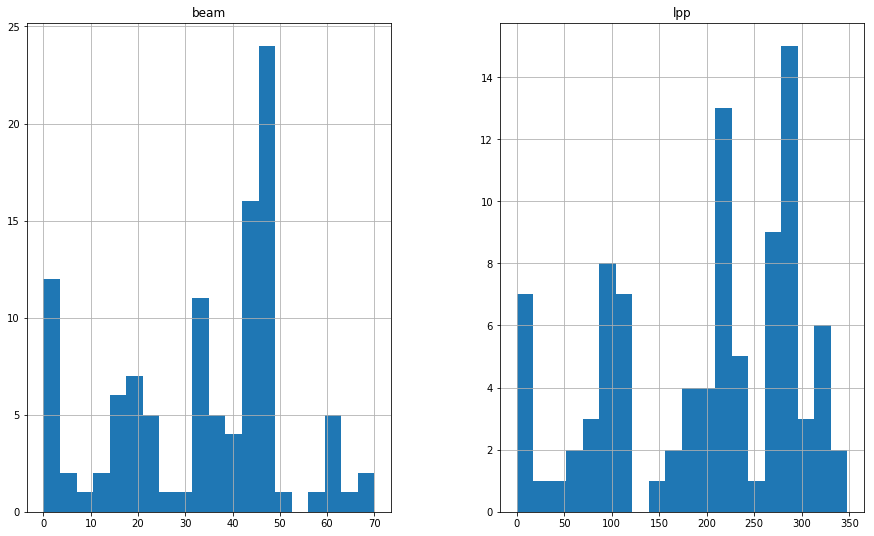

In [8]:
df_ships.hist(bins=20)

In [9]:
roll_decay_test = roll_decay_tests[0]

In [10]:
tables = ['min','mean','max','std']
statistics = {}
for table in tables:
    statistics[table] = pd.read_sql_table(table_name=table, con=engine)

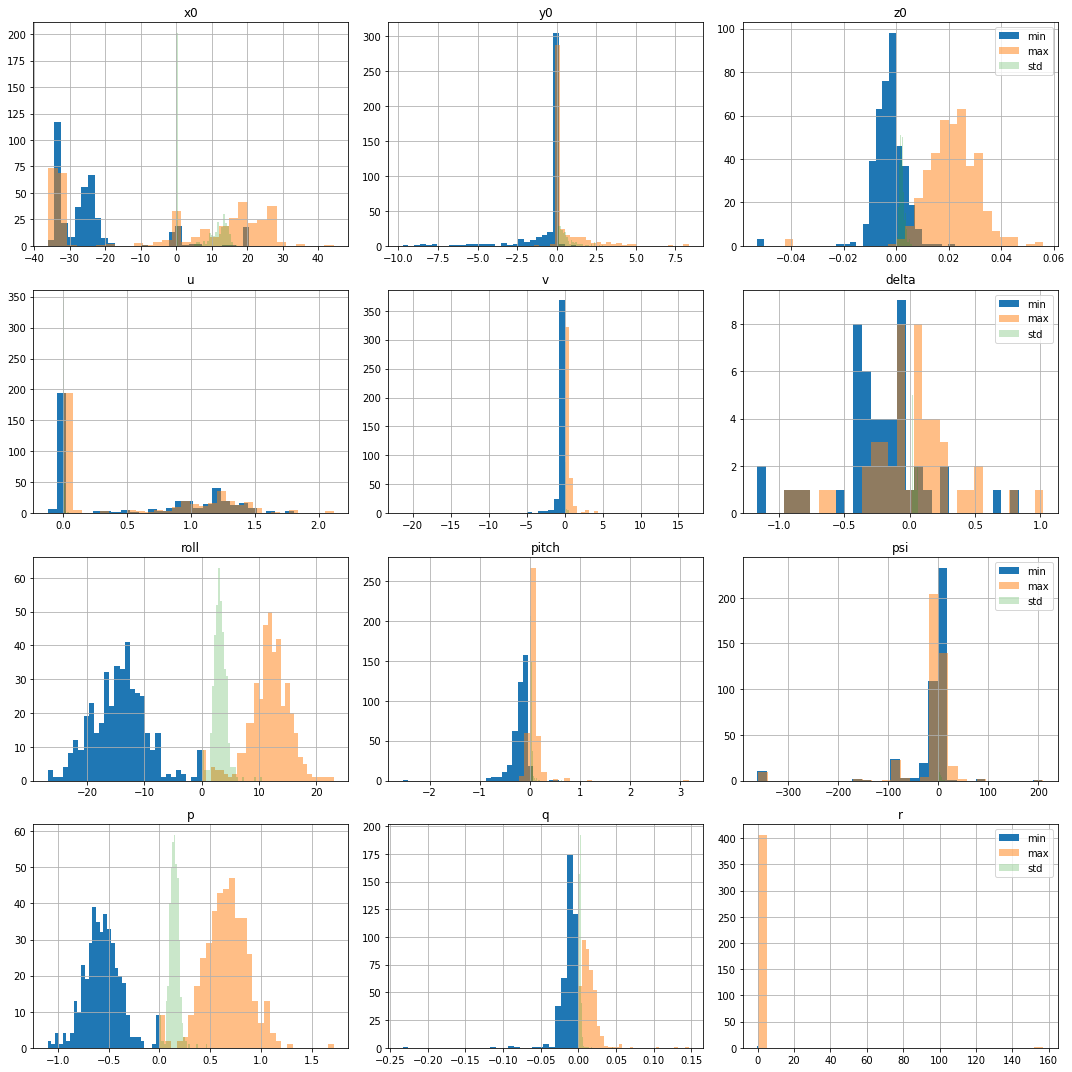

In [11]:
plots = [['x0','y0','z0'],
         ['u','v','delta'],
         ['roll','pitch','psi'],
         ['p','q','r']]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        min = statistics['min']
        max = statistics['max']
        std = statistics['std']
        
        bins = 30
        min[plot].hist(label='min', bins=bins, ax=ax)
        max[plot].hist(label='max', bins=bins, ax=ax, alpha=0.5)
        std[plot].hist(label='std', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

### Comments
* All values above are in model scale. 
* Speed up to 2 m/s in model scale
* Rudder angle ($\delta$) is not used during test, but can have fixed initial angle to keep the model on a straight course.
* Max roll can be up to 25 degrees!
* The pitch is static (no standard deviation) so it is basically trim due to speed
* p, q and r are rotational velocities for roll, pitch and yaw.


In [12]:
cols = ['roll','psi','u','r']
min[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,-14.354498,-17.665514,0.550688,-0.018214
std,4.852812,61.347784,0.603502,0.011007
min,-26.860000,-361.619797,-0.122843,-0.067245
25%,-17.305000,-4.765744,-0.013846,-0.023998
50%,-14.160000,-0.719400,0.279571,-0.016032
75%,-11.415000,-0.032600,1.174762,-0.009942
max,0.005000,207.702791,2.018690,-0.002182


In [13]:
max[cols].describe()

,roll,psi,u,r
count,407.000000,407.000000,407.000000,407.000000
mean,11.733146,-10.616949,0.594980,0.406797
std,3.665115,60.102102,0.613089,7.785212
min,0.000900,-360.046997,0.002522,0.002182
25%,9.965000,-0.057686,0.012196,0.010908
50%,11.980000,0.734857,0.301464,0.017964
75%,14.070000,2.925701,1.216718,0.028362
max,23.000000,210.517791,2.117975,157.081401


In [14]:
std[cols].describe()

,roll,psi,u,r
count,406.000000,407.000000,407.000000,407.000000
mean,3.098627,1.740753,0.006957,0.012714
std,1.154276,2.450445,0.013807,0.153974
min,0.000191,0.002432,0.000956,0.000230
25%,2.433426,0.250915,0.002915,0.002489
50%,3.031317,0.656507,0.004814,0.004314
75%,3.732001,2.077588,0.007300,0.006954
max,10.478363,13.044742,0.232787,3.110646


In [15]:
rolldecay_linear = pd.read_sql_table(table_name='rolldecay_linear', con=engine, index_col='run_id')
rolldecay_direct = pd.read_sql_table(table_name='rolldecay_direct', con=engine, index_col='run_id')
rolldecay_norwegian = pd.read_sql_table(table_name='rolldecay_norwegian', con=engine, index_col='run_id')

def remove_outliers(df, abs_percentile=0.01, min_score=0.97):
    mask1 = ((df.quantile(abs_percentile) < df) &
            (df < df.quantile(1-abs_percentile)) 
           )
    
    mask2 = df['score'] >= min_score
    return df[mask1].loc[mask2].copy()

rolldecay_linear = remove_outliers(rolldecay_linear)
rolldecay_direct = remove_outliers(rolldecay_direct)
rolldecay_norwegian = remove_outliers(rolldecay_norwegian)

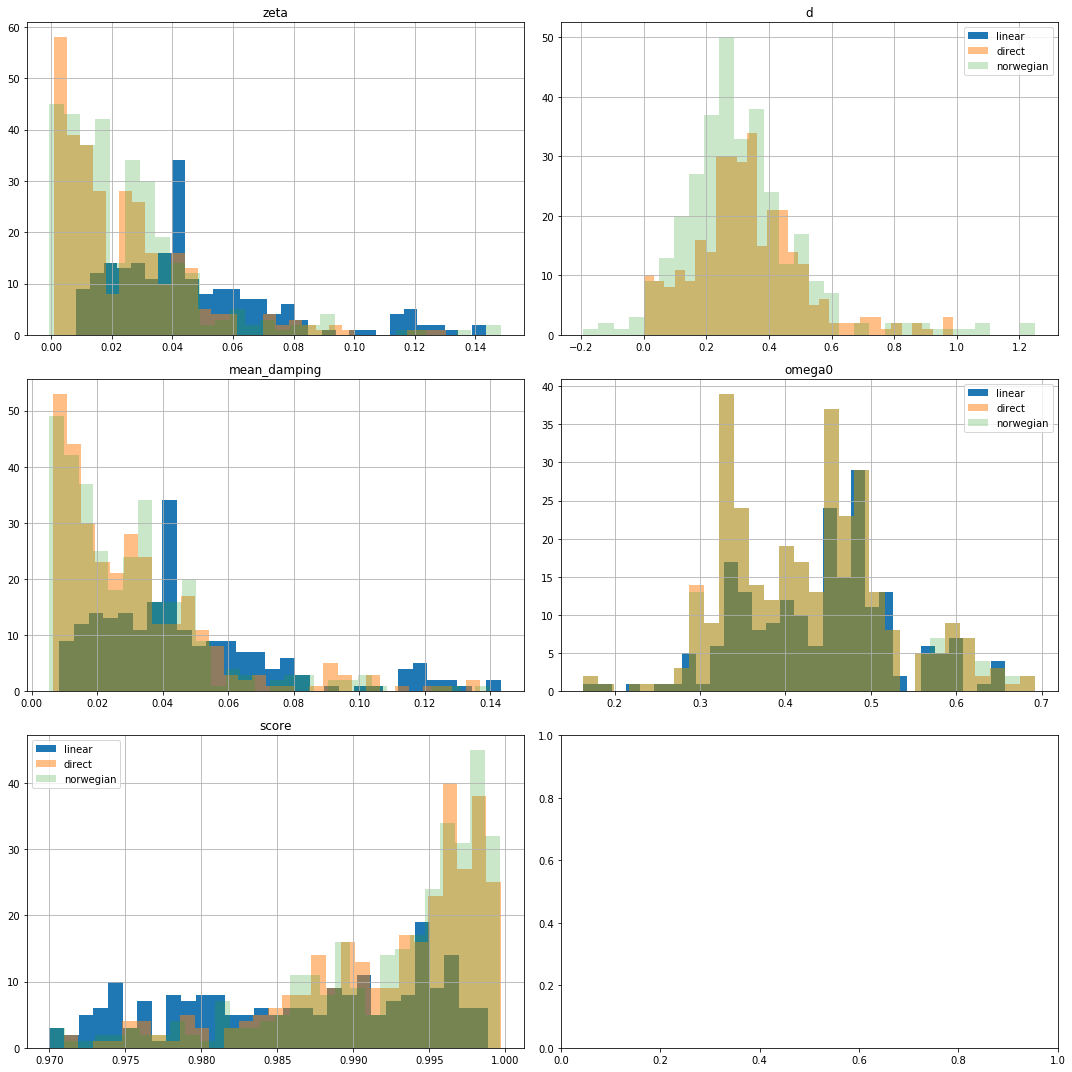

In [16]:
plots = [['zeta','d'],
         ['mean_damping','omega0'],
         ['score'],
        ]
nrows = len(plots)
ncols = 0
for subplots in plots:
    if len(subplots) > ncols:
        ncols = len(subplots)

fig,axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.set_size_inches(15,15)

for row, subplots in enumerate(plots):
    for col, plot in enumerate(subplots):
        
        ax = axes[row,col]
        
        bins = 30
        rolldecay_linear[plot].hist(label='linear', bins=bins, ax=ax)
        rolldecay_direct[plot].hist(label='direct', bins=bins, ax=ax, alpha=0.5)
        rolldecay_norwegian[plot].hist(label='norwegian', bins=bins, ax=ax, alpha=0.25)
        
        
        ax.set_title(plot)

    ax.legend()
plt.tight_layout()

### Comments

So we now know that mean_damping is in the range 0-0.15...

In [17]:
rolldecay_linear.describe()

,d,mean_damping,omega0,score,zeta
count,0.0,206.000000,209.000000,208.000000,206.000000
mean,NaN,0.047703,0.440709,0.986469,0.047703
std,NaN,0.028991,0.088642,0.008163,0.028991
min,NaN,0.008368,0.163377,0.970012,0.008368
25%,NaN,0.027133,0.373744,0.979639,0.027133
50%,NaN,0.041816,0.451561,0.988141,0.041816
75%,NaN,0.059042,0.489455,0.994147,0.059042
max,NaN,0.143350,0.657524,0.998876,0.143350


In [18]:
rolldecay_direct.describe()

,d,mean_damping,omega0,score,zeta
count,315.000000,310.000000,314.000000,313.000000,310.000000
mean,0.333709,0.030647,0.425872,0.992475,0.024111
std,0.178111,0.023918,0.094370,0.006317,0.022347
min,0.000048,0.006414,0.163377,0.970944,0.000880
25%,0.233062,0.012628,0.347272,0.989030,0.006790
50%,0.315264,0.025214,0.428230,0.994794,0.017385
75%,0.426813,0.040494,0.484027,0.997389,0.032600
max,0.988415,0.136931,0.692322,0.999717,0.130446


In [19]:
rolldecay_norwegian.describe()

,d,mean_damping,omega0,score,zeta
count,318.000000,317.000000,318.000000,317.000000,319.000000
mean,0.313011,0.029739,0.429298,0.992524,0.024789
std,0.202679,0.022531,0.096513,0.006674,0.023462
min,-0.192577,0.005408,0.163377,0.970060,-0.000511
25%,0.196946,0.012683,0.348426,0.988973,0.008140
50%,0.284463,0.025013,0.431966,0.995096,0.018302
75%,0.391115,0.038974,0.486371,0.997597,0.032263
max,1.250149,0.139938,0.692322,0.999614,0.148451


c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
c:\dev\rolldecay\venv\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


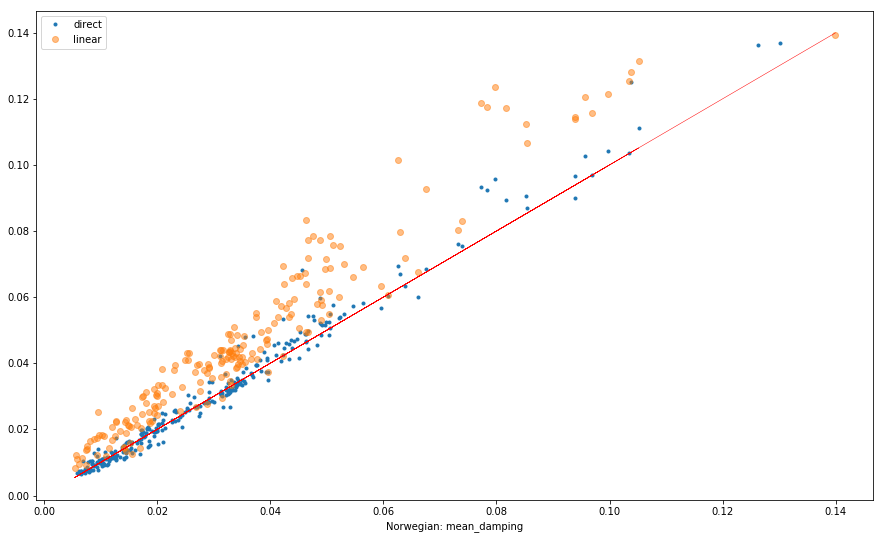

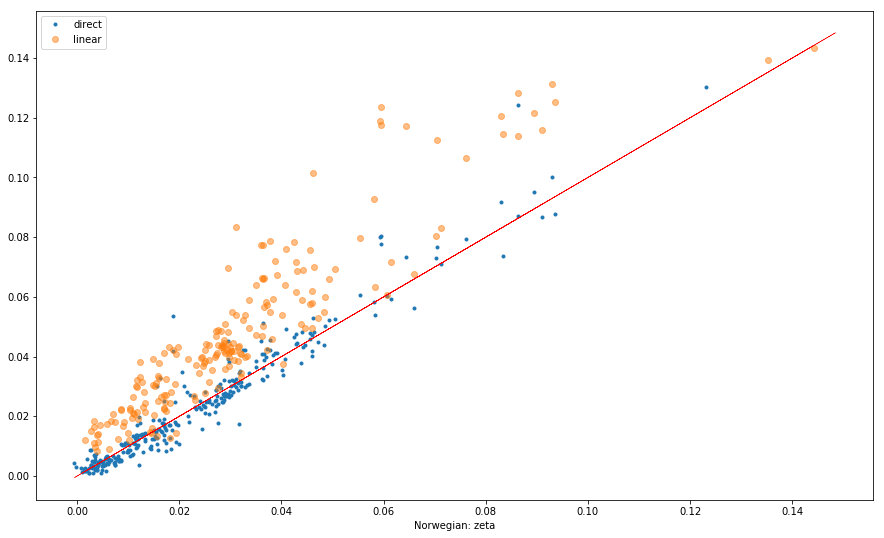

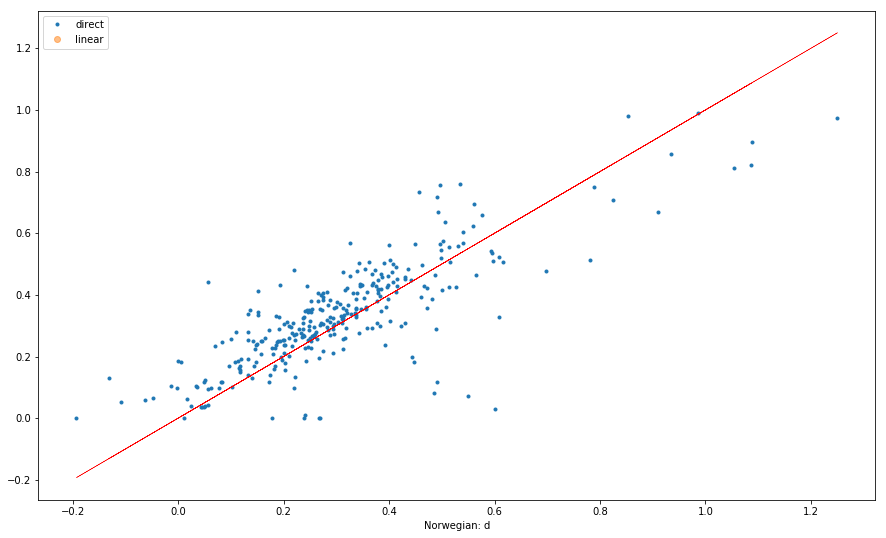

In [20]:
for key in ['mean_damping','zeta','d']:
    
    fig,ax = plt.subplots()
    x = rolldecay_norwegian[key]
    y = rolldecay_direct.loc[rolldecay_norwegian.index][key]
    y2 = rolldecay_linear.loc[rolldecay_norwegian.index][key]
    
    ax.plot(x,y,'.', label='direct')
    ax.plot(x,y2,'o', label='linear', alpha=0.5)
    ax.set_xlabel('Norwegian: %s' % key)
    ax.legend();
    ax.plot(x,x,'r-')
    


### Comments
* Norwegian method and direct method give differnet results which is not very satisfying.
* Linear method gives higher mean damping, which is a bit strange.

In [43]:
sql="""
SELECT * from
rolldecay_linear
INNER JOIN run
ON rolldecay_linear.run_id == run.id
    INNER JOIN loading_conditions
    ON run.loading_condition_name == loading_conditions.name
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)
df_rolldecay = df_rolldecay.loc[:,~df_rolldecay.columns.duplicated()]
df_rolldecay = remove_outliers(df_rolldecay)
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,ship_speed,lcg,kg,gm,scale_factor,lpp,beam
count,0.0,1028.000000,1033.000000,1028.000000,1028.000000,1042.00000,1.000000e+03,1018.000000,1019.000000,0.0,973.000000,1020.000000,960.000000,995.000000,1001.000000,978.000000,999.000000
mean,NaN,0.045755,0.431557,0.986931,0.045755,10512.78215,2.058105e+07,10.022593,26.130520,NaN,13.296095,2.247134,13.974848,6.954705,52.849907,263.166452,43.324585
std,NaN,0.019514,0.070718,0.007839,0.019514,5512.38751,2.751564e+06,13.562213,10.453736,NaN,7.237923,15.726368,3.021964,3.961975,7.354123,48.861342,6.974006
min,NaN,0.012273,0.260558,0.970012,0.012273,832.00000,2.006417e+07,1.000000,3.000000,NaN,1.000000,-9.514000,5.190000,0.570000,24.000000,45.100000,15.010000
25%,NaN,0.033585,0.372215,0.980987,0.033585,7498.00000,2.010554e+07,1.000000,20.000000,NaN,10.000000,-1.400000,12.160000,3.690000,50.000000,278.000000,44.000000
50%,NaN,0.043142,0.438143,0.988340,0.043142,8703.00000,2.012615e+07,10.000000,27.000000,NaN,17.000000,0.000000,14.370000,6.900000,55.000000,279.000000,45.800000
75%,NaN,0.058809,0.486781,0.994025,0.058809,15020.00000,2.013653e+07,11.000000,32.000000,NaN,18.800000,0.631000,16.750000,9.740000,58.700000,284.000000,46.950000
max,NaN,0.120573,0.645950,0.998841,0.120573,20588.00000,4.008482e+07,101.000000,68.000000,NaN,20.300000,135.530000,18.650000,20.110000,71.430000,302.000000,50.000000


In [44]:
df_rolldecay.columns

Index(['d', 'mean_damping', 'omega0', 'score', 'zeta', 'id', 'project_number',
       'series_number', 'run_number', 'test_number', 'model_number',
       'ship_name', 'loading_condition_name', 'ascii_name', 'ship_speed',
       'comment', 'file_path_ascii', 'file_path_log', 'file_path_hdf5', 'date',
       'test_type', 'facility', 'angle1', 'angle2', 'name', 'lcg', 'kg', 'gm',
       'scale_factor', 'lpp', 'beam'],
      dtype='object')

In [45]:
df_rolldecay.describe()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,ship_speed,lcg,kg,gm,scale_factor,lpp,beam
count,0.0,1028.000000,1033.000000,1028.000000,1028.000000,1042.00000,1.000000e+03,1018.000000,1019.000000,0.0,973.000000,1020.000000,960.000000,995.000000,1001.000000,978.000000,999.000000
mean,NaN,0.045755,0.431557,0.986931,0.045755,10512.78215,2.058105e+07,10.022593,26.130520,NaN,13.296095,2.247134,13.974848,6.954705,52.849907,263.166452,43.324585
std,NaN,0.019514,0.070718,0.007839,0.019514,5512.38751,2.751564e+06,13.562213,10.453736,NaN,7.237923,15.726368,3.021964,3.961975,7.354123,48.861342,6.974006
min,NaN,0.012273,0.260558,0.970012,0.012273,832.00000,2.006417e+07,1.000000,3.000000,NaN,1.000000,-9.514000,5.190000,0.570000,24.000000,45.100000,15.010000
25%,NaN,0.033585,0.372215,0.980987,0.033585,7498.00000,2.010554e+07,1.000000,20.000000,NaN,10.000000,-1.400000,12.160000,3.690000,50.000000,278.000000,44.000000
50%,NaN,0.043142,0.438143,0.988340,0.043142,8703.00000,2.012615e+07,10.000000,27.000000,NaN,17.000000,0.000000,14.370000,6.900000,55.000000,279.000000,45.800000
75%,NaN,0.058809,0.486781,0.994025,0.058809,15020.00000,2.013653e+07,11.000000,32.000000,NaN,18.800000,0.631000,16.750000,9.740000,58.700000,284.000000,46.950000
max,NaN,0.120573,0.645950,0.998841,0.120573,20588.00000,4.008482e+07,101.000000,68.000000,NaN,20.300000,135.530000,18.650000,20.110000,71.430000,302.000000,50.000000


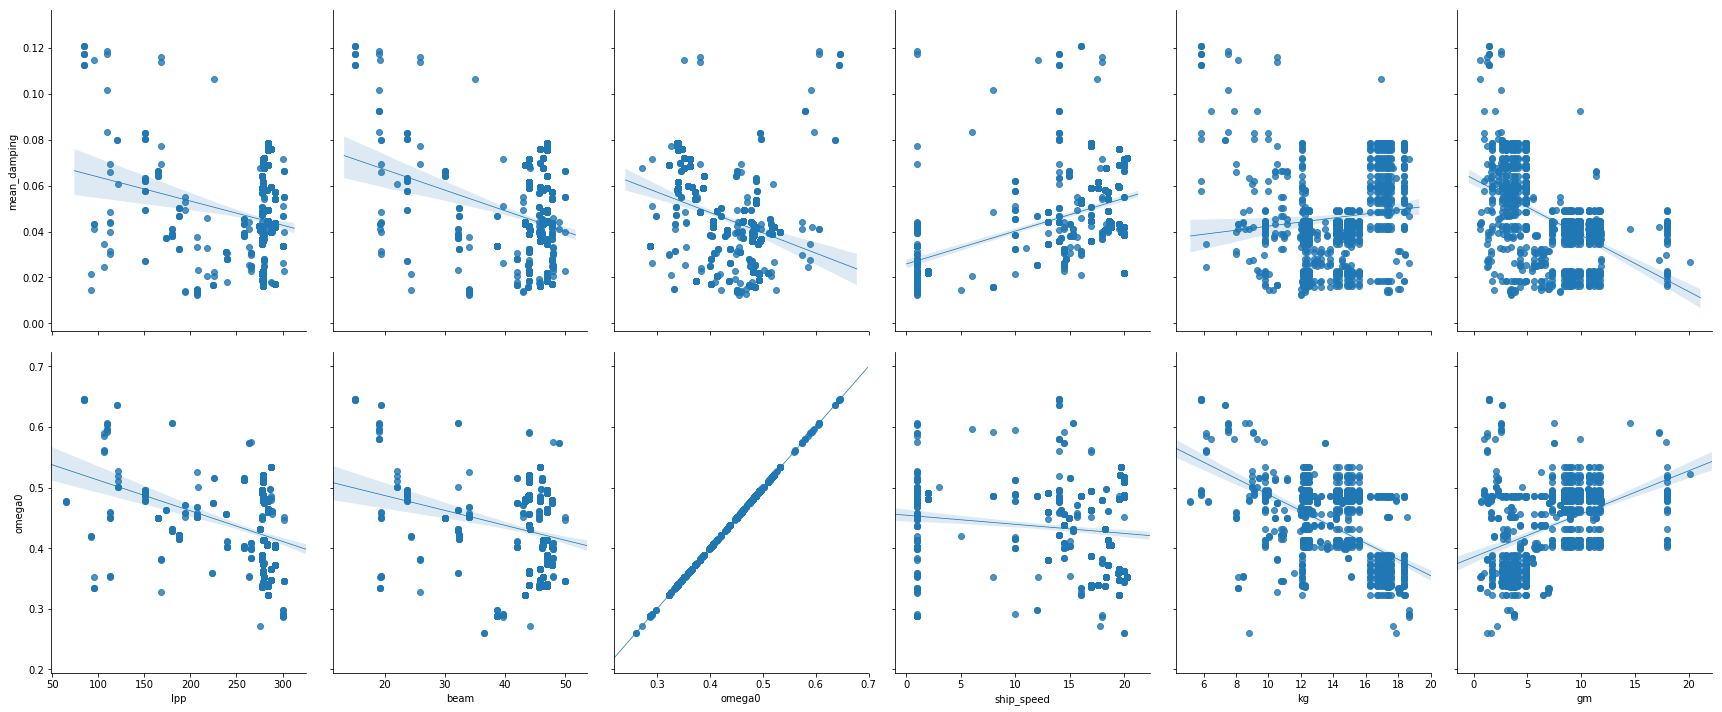

In [46]:
x_vars = ['lpp','beam','omega0','ship_speed','kg','gm']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['mean_damping','omega0'],
             height=5, aspect=.8, kind="reg");

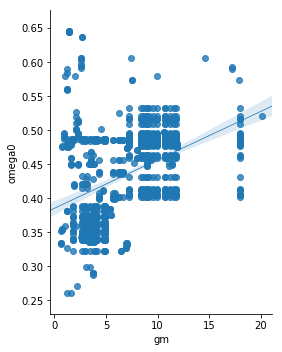

In [47]:
x_vars = ['gm']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['omega0'],
             height=5, aspect=.8, kind="reg");

Text(0.5, 1.0, 'kxx')

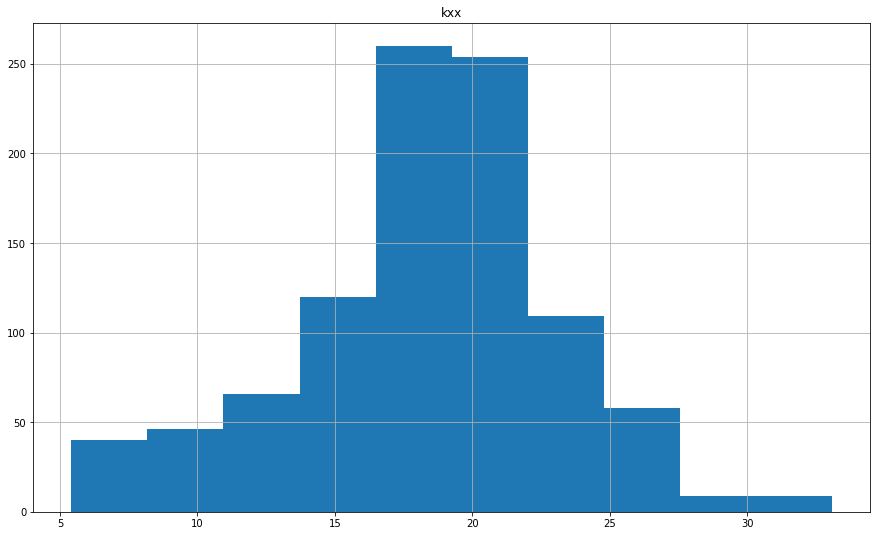

In [51]:
omega0 = df_rolldecay['omega0']
GM = df_rolldecay['gm']
g = 9.81
kxx = 1/omega0*np.sqrt(g*GM)  # "Sunes equation"
fig,ax = plt.subplots()
kxx.hist(ax=ax);
ax.set_title('kxx')


## Comment
kxx should be nondimensional rxx/beam which is clearly not the case...

In [24]:
df_rolldecay['beam_'] = df_rolldecay['beam']/df_rolldecay['lpp']

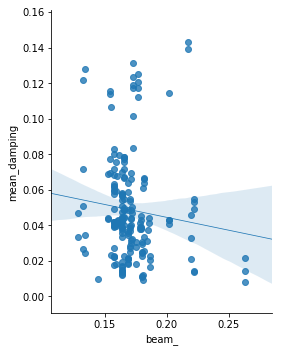

In [25]:
x_vars = ['beam_']
sns.pairplot(df_rolldecay, x_vars=x_vars, y_vars=['mean_damping'],
             height=5, aspect=.8, kind="reg");